# LDA Model

## LDA is shorted for Latent Dirchlet allocation model. It is a topic model commonly used for document. Here I demonstrate the canonical LDA for unsupervised learning and a modified (guidedLDA) version for semisupervised learning for classification.

## Table of Contents

1. [Load and cleaning](#data_eda)

    1.1 [Load data](#data)
    
    1.2 [Cleaing the text data](#eda)
    
    1.3 [An example text data after cleaning](#example)
    
    1.4 [An vocabulary set contains all the variations](#var_dict)
    
    1.5 [Split train data by train-test](#split)
    
2. [LDA unsupervised](#lda_un)

    2.1 [An vocabulary set contains variations and the most common words](#all_dict)
    
    2.2 [TF vectorizer](#vectorization1)
    
    2.3 [Train LDA model using TF matrix](#'train_lda')
    
    2,4 [Example words belonging to LDA topics](#'topic_words')
    
    2.5 [Plot the clusters of LDA topics](#'plot_topic_words')
    
3. [Classification using guided LDA](#guided)

    3.1 [TF for guided LDA](#'tf_guide')

    3.2 [Construct a guide set using train data](#'seed')
    
    3.3 [guided LDA model](#'glda') 
    
    3.4 [Example words belonging to guided LDA topics](#'topic_words:glda)
    
    3,5 [Evaluation - Confusion matrix and F1 score](#'glda_eval')
    
    3.6 [Model selection - Parameter Gridsearch](#'param')

In [118]:
%load_ext autoreload
%autoreload 2

import numpy as np

import pandas as pd
from lib import utils
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix, f1_score

import seaborn as sns
import time, re
import sys, os
import pickle
from imblearn.over_sampling import SMOTE


import codecs
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence

import spacy
nlp = spacy.load('en')

from IPython.display import display

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='data'></a>
### Data

In [119]:
data_dir = './data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
train_clean_text_path = os.path.join(data_dir, 'train_clean_text.csv') 

train = utils.TrainDataSet('./data/training_variants', './data/training_text')
test = utils.TestDataSet('./data/test_variants', './data/test_text')

display(train.show_documents())

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


<a id='eda'></a>
### Clean the text data

In [120]:
# clean text data
train.extract_prof_text()
train.dataset_clean = train.dataset_clean.dropna(how='any', axis=0)
train.text_length(train.dataset_clean)
train.lemmatize(train.dataset_clean)
train.lemmatize(train.dataset_clean, col='Gene')
train_variation_class_pair = train.variation_class()
display(train.dataset_clean.head())
display(train_variation_class_pair.head())
# same for test data
test.extract_prof_text()
test.dataset_clean = test.dataset_clean.drop(['Text','Gene','Variation'], axis=1)
test.dataset_clean = test.dataset_clean.dropna(how='any', axis=0)
test.text_length(test.dataset_clean)
test_variation= test.dataset_clean[['Variation_lemmatized']]

,ID,Gene,Variation,Class,Text,text_prof_tokens,Variation_lemmatized,Gene_lemmatized,text_length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin kinase cdk cdk1 cdk cyclin kinase cdk1 ...,truncate mutation,fam58a,893
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,nsclc proteomic cbl ubiquitin ligase cbl tyros...,w802 *,cbl,624
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,nsclc proteomic cbl ubiquitin ligase cbl tyros...,q249e,cbl,624
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,uniparental disomy aupd pathogenetic homozygos...,n454d,cbl,791
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,monomeric casitas cbl cbl cbl missense cbl cbl...,l399v,cbl,616


,Variation_lemmatized,Class
0,truncate mutation,1
1,w802 *,2
2,q249e,2
3,n454d,3
4,l399v,4


In [121]:
#train.text = train_text_var['text_prof_tokens']
#test.text = test_text_var['text_prof_tokens']

text_var_merged =  pd.concat([train.dataset_clean[['text_prof_tokens', 'Variation_lemmatized']], 
                              test.dataset_clean[['text_prof_tokens', 'Variation_lemmatized']]])

### We append several variance data to the text data to emphasis their existance in the associated text documents. Intuitivly, in the training step using LDA, these additionally appended vaiantion information will emphasize the topic associated with the variations in the text document.

In [122]:
# text data has been appended with variation data

text_var_train = train.dataset_clean.copy().groupby(['text_prof_tokens'])['Variation_lemmatized'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
text_var_train['text_prof_tokens'] = text_var_train['text_prof_tokens'] + ' '+ text_var_train['Variation_lemmatized'].apply(lambda x: ' '+ ' '.join(x.split('-')))*text_var_train['text_prof_tokens'].apply(lambda x: len(x.split(' '))//100)

text_var_test = test.dataset_clean.groupby(['text_prof_tokens'])['Variation_lemmatized'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
text_var_test['text_prof_tokens'] = text_var_test['text_prof_tokens'] + ' '+ text_var_test['Variation_lemmatized'].apply(lambda x: ' '+ ' '.join(x.split('-')))*text_var_test['text_prof_tokens'].apply(lambda x: len(x.split(' '))//100)

text_var_merged = text_var_merged.groupby(['text_prof_tokens'])['Variation_lemmatized'].apply(lambda x: ' '.join(x.astype(str))).reset_index()
text_var_merged['text_prof_tokens'] = text_var_merged['text_prof_tokens'] + ' '+ text_var_merged['Variation_lemmatized'].apply(lambda x: ' '+ ' '.join(x.split('-')))*text_var_merged['text_prof_tokens'].apply(lambda x: len(x.split(' '))//100)


<a id='example'></a>
### An example of cleaned text doc

In [123]:
# an example text data after cleaning:
text_var_merged.loc[4999]['text_prof_tokens'][:1000]

'oncogenesis morphological prognostic genomic mycn phox2b homeobox autosomal nucleotide snps germline alk genomic amplicon mycn alk tyrosine kinase germline r1275q r1275q alk tyrosine alk y16 alk kinase alk janoueix lerosey janoueix lerosey snp alk kinase alk r1275q f1174l tyrosine endogenously alk cells6 alk neuroblastoma alk f1174 alk r1275q difference8 alk alk alk genomic clonal multigene tumorigenesis sensitivity8 alk alk alk rnai endogenous alk kinase alk rnai alk alk tumorigenesis alk f1174l myoblastic alk kinase crizotinib ranbp2 alk translocation alk f1174l myoblastic alk f1174l phosphorylat alk f1174l alk alk alk kinase activity1 eml4 alk cancers11 crizotinib effectively12 alk kinase kinase alk emerges13 alk outcome8 alk pleiotrophin midkine alk14 extracellular alk syn ergistically tyrosine kinase alk alk anaplastic kinase alk tyrosine kinase genomic alk alk tyrosine kinase constitutively crizotinib alk genomic alk neuroblastomas embryonal gd2 hobbie anaplastic kinase alk tyro

<a id='var_dict'></a>
### An vocabulary set contains all the variations

In [124]:
var_test = ' '.join([v for v in test.dataset_clean['Variation_lemmatized'] if len(v)>2]) + ' '.join(train.dataset_clean['Variation_lemmatized'])
all_vars = var_test.split(' ')
all_vars = [v for v in all_vars if len(v)>2]
len(all_vars)

9269

<a id='split'></a>
### split train data by train-test 

In [125]:
from lib.utils import split_train_test
train_train, train_test = split_train_test(train_variation_class_pair, test_ratio=0.2, shuffle=True)

<a id='lda_un'></a>
# The LDA model

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

<a id='all_dict'></a>
### An vocabulary set contains all the variations and the most common words in the texts

In [127]:
# merge the cleaned text data in train and test 
merged_text = text_var_merged['text_prof_tokens'].copy()

In [128]:
fn_tf_vectroizer_plain = './models/tf_vectroizer_plain.pkl'
fn_tf_plain = './models/tf_plain.pkl'

if True:#not os.path.exists('./models/tf_vectroizer_plain.pkl'):
    tf_vectroizer_plain =  CountVectorizer(max_df= 0.05, min_df = 0.0, 
                                           max_features=2000,
                                           stop_words = 'english')
    tf_plain = tf_vectroizer_plain.fit_transform(merged_text)
        
    with open(fn_tf_vectroizer_plain, 'wb') as fid:
        pickle.dump(tf_vectroizer_plain, fid)
    with open(fn_tf_plain, 'wb') as fid:
        pickle.dump(tf_plain, fid)
else:
    with open(fn_tf_vectroizer_plain, 'rb') as fid:
        tf_vectroizer_plain = pickle.load(fid)
    with open(fn_tf_plain, 'rb') as fid:
        tf_plain = pickle.load(fid)
        

# make sure the vocabulary contains all the variables of train data
vocabulary_var = set(all_vars)
print("numer of variations in vocabulary: {}".format(len(vocabulary_var)))
vocabulary_all = vocabulary_var.copy()
vocabulary_all.update(tf_vectroizer_plain.get_feature_names())
print("number of words in vocabulary:{}".format(len(vocabulary_all)))

numer of variations in vocabulary: 8467
number of words in vocabulary:10282


<a id='vectorization1'></a>
### TF vectorizer

In [129]:
fn_tf = './models/tf.pkl'
fn_tf_vectorizer = './models/tf_vectorizer.pkl'
if True: #  (os.path.exists(fn_tf_vectorizer) and os.path.exists(fn_tf)):
    tf_vectroizer =  CountVectorizer(max_df= 0.5, min_df = 0.00, 
                                     vocabulary = vocabulary_all,
                                     stop_words = 'english')
    tf = tf_vectroizer.fit_transform(merged_text)
        
    with open(fn_tf, 'wb') as fid:
        pickle.dump(tf, fid)
    with open(fn_tf_vectorizer, 'wb') as fid:
        pickle.dump(tf_vectroizer, fid)
else:
    with open(fn_tf, 'rb') as fid:
        tf = pickle.load(fid)
    with open(fn_tf_vectorizer, 'rb') as fid:
        tf_vectorizer = pickle.load(fid)

In [130]:
tf.shape

(7387, 10282)

<a id='train_lda'></a>
### Train LDA model using TF matrix

In [131]:
fn = './models/lda_tf_topics.pkl'

if True: #not os.path.exists('./models/lda_tf_topics.pkl'):
    lda = LatentDirichletAllocation(n_topics=9, max_iter=20,
                                    learning_method='online',
                                    learning_offset=10,
                                    random_state=0)
    lda_tf = lda.fit(tf)
    lda_tf_topics = lda.fit_transform(tf)
    with open(fn, 'wb') as fid:
        pickle.dump(lda_tf_topics, fid)
else:
    with open(fn, 'rb') as fid:
        lda_tf_topics = pickle.load(fid)

<a id='topic_words'></a>
### Example words belonging to LDA topics

In [132]:
# Find for each topic (9 topics in total), the words(most possible) it contains. 

n_top_words = 5

topic_summaries = []
topic_word = lda.components_  # all topic words
vocab = tf_vectroizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
    topic_summaries.append(' '.join(topic_words)) # append!
    
for i, words in enumerate(topic_summaries):
    print("{} topic words:".format(i) + "\n"  +  words) 

0 topic words:
flt3 jak2 bcr v617f abl1
1 topic words:
fgfr1 lats1 med12 missense overexpression
2 topic words:
pdgfra exon ptprd sox9 ponatinib
3 topic words:
alk ros1 fusion hamartin ntrk1
4 topic words:
mll missense exon setd2 overexpression
5 topic words:
braf fgfr3 fusion overexpression yap1
6 topic words:
missense exon fig rad51c mh2
7 topic words:
egfr l858r missense exon ddr2
8 topic words:
runx1 nucleotide cdk12 erbb4 overexpression


<a id='plot_topic_words'></a>
### Plot the clusters of LDA topics

In [133]:
from sklearn.manifold import TSNE

threshold = 0.5
_idx = np.amax(lda_tf_topics, axis=1) > threshold  # idx of doc that above the threshold
lda_tf_topics = lda_tf_topics[_idx]

_lda_keys = []
for i in range(lda_tf_topics.shape[0]):
    _lda_keys +=  lda_tf_topics[i].argmax(),

tsne_model = TSNE(n_components=2, 
                  perplexity=30.0,
                  verbose=1, 
                  random_state=0, 
                  angle=0.99, 
                  init='pca')
tsne_lda = tsne_model.fit_transform(lda_tf_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6771 samples in 0.003s...
[t-SNE] Computed neighbors for 6771 samples in 0.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6771
[t-SNE] Computed conditional probabilities for sample 2000 / 6771
[t-SNE] Computed conditional probabilities for sample 3000 / 6771
[t-SNE] Computed conditional probabilities for sample 4000 / 6771
[t-SNE] Computed conditional probabilities for sample 5000 / 6771
[t-SNE] Computed conditional probabilities for sample 6000 / 6771
[t-SNE] Computed conditional probabilities for sample 6771 / 6771
[t-SNE] Mean sigma: 0.004750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.525436
[t-SNE] Error after 1000 iterations: 0.834653


Each word in the vocabulary has been assigned to a topic which associated to its maximum probability. All Variations are contained in this vocabulary. Thus, each Variation has been assigned to a topic.


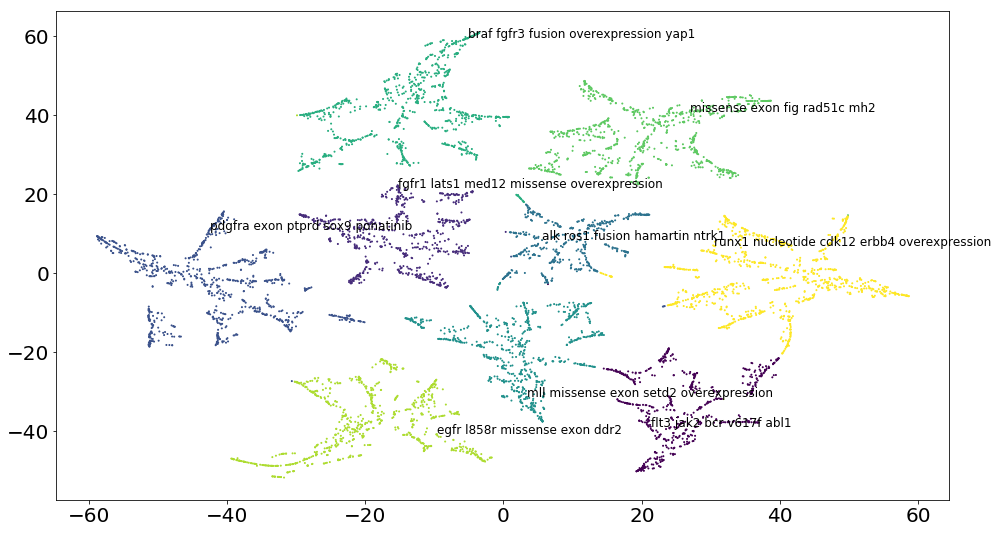

In [149]:
plt.rcParams["figure.figsize"] = [16,9]
plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c = _lda_keys, s=1)

topic_coord = np.empty((lda_tf_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
    if not np.isnan(topic_coord).any():
        break
    topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]
for i in range(lda_tf_topics.shape[1]):
    plt.text(topic_coord[i, 0], topic_coord[i, 1],  topic_summaries[i], fontsize=12)

plt.show()

<a id='guided'></a>
# Semisupervised Classification using guided LDA

### using lda we can get the topic of each word, especially, the topic associated to each Variation. We use the variation-class pair in the data train_train to assign the topics to the classes. And use the train_test data for validation.

### To achieve this I applied a semisupervised LDA

### guided LDA employs a seeds set with known class labels to "guide" the distribution of the LDA classification, hence it is a semisupervised classifier.

In [135]:
import guidedlda
print(len(vocabulary_var))

8467


<a id='tf_guide'></a>
### TF for guided LDA

In [136]:
tf_vectroizer =  CountVectorizer(max_df= 0.1, min_df = 0.0, 
                                     vocabulary = list(vocabulary_var),
                                     stop_words = 'english')
tf = tf_vectroizer.fit_transform(merged_text)


vocab = tf_vectroizer.get_feature_names()
print(len(vocab))

8467


In [137]:
idx = []
not_found = []
for var in np.array(train_train['Variation_lemmatized']):
    try:
        idx.append(vocab.index(var)) 
    except: 
        not_found.append(var)
        idx.append(-1)

<a id='seed'></a>
### Construct a guide set using train data

In [138]:
n_topics = 9

seed_topic_list = [[] for i in range(n_topics)]
for idx in train_train.index:
    var = train_train.loc[idx]['Variation_lemmatized']
    seed_topic_list[train_train.loc[idx]['Class'] -1].extend(train_train.loc[idx]['Variation_lemmatized'].split(' '))


seed_topic_list = [[v  for v in l if len(v)>2 and v not in ['truncate', 'mutation', 'deletion', 'amplification', 'fusion', 'overexpression']] for l in seed_topic_list]

test_topic_list = [[] for i in range(n_topics)]
for idx in train_test.index:
    var = train_test.loc[idx]['Variation_lemmatized']
    test_topic_list[train_test.loc[idx]['Class'] -1].extend(train_test.loc[idx]['Variation_lemmatized'].split(' '))

test_topic_list = [[v  for v in l if len(v)>2 and v not in ['truncate', 'mutation', 'deletion', 'amplification', 'fusion', 'overexpression']] for l in test_topic_list]
# test_topic_list

merged_classes = [[i] for i in range(n_topics)]

"""Try some group combinations?"""
# merged_classes = [[0,4],[5,7],[8,1], [3], [6]]
# merged_classes = [[0,4,2,7,8], [5],[1,6]]

n_topics= len(merged_classes)
seed_topic_list_=[[] for i in range(n_topics)]
i=0
for m in merged_classes:
    for mi in m:
        seed_topic_list_[i].extend(seed_topic_list[mi])
    i+=1

weight =np.array([len(l) for l in seed_topic_list_])
weight=weight/np.sum(weight)
print(weight)

test_topic_list_=[[] for i in range(n_topics)]
i=0
for m in merged_classes:
    for mi in m:
        test_topic_list_[i].extend(test_topic_list[mi])
    i+=1
    
seed_topic_list = seed_topic_list_
test_topic_list = test_topic_list_

[ 0.13841114  0.13636364  0.03030303  0.22276822  0.07862408  0.08886159
  0.28378378  0.00737101  0.01351351]


In [139]:
seed_topics = {}

for t_id, st in enumerate(seed_topic_list):
    for word in st:
        try: 
            index = vocab.index(word)
        except:
            index = vocab.index(word[0])
        seed_topics[index] = t_id 

In [140]:
# seed_topic_list

<a id='glda'></a>
### guided LDA model

In [141]:
# model = guidedlda.GuidedLDA(n_topics=9, n_iter=100, alpha=0.01, eta=0.001, random_state=7, refresh=50)
# model.fit(tf, seed_topics=seed_topics, seed_confidence=0.9999)#

In [142]:
# n_top_words = 10
# topic_word = model.topic_word_
# for i, topic_dist in enumerate(topic_word):
#     topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
#     print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [143]:
model = guidedlda.GuidedLDA(n_topics=n_topics, n_iter=50, alpha=0.0001, eta=0.001, random_state=7, refresh=50)
model.fit(tf, seed_topics=seed_topics, seed_confidence=1.0)#

INFO:guidedlda:n_documents: 7387
INFO:guidedlda:vocab_size: 8467
INFO:guidedlda:n_words: 1265803
INFO:guidedlda:n_topics: 9
INFO:guidedlda:n_iter: 50
INFO:guidedlda:<0> log likelihood: -10452823
INFO:guidedlda:<49> log likelihood: -7366362


<a id='topic_words:glda'></a>
### Example words belonging to guided LDA topics

In [144]:
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))


Topic 0: missense exon truncate overexpression epigenetic nucleotide r273h mutation truncating r249s
Topic 1: pdgfra bcr exon pdgfrb d842v v56 overexpression v654a d816v t67
Topic 2: fgfr1 fusion fig overexpression erg fgfr3 exon nucleotide bcr wildtype
Topic 3: missense exon nucleotide polymorphism tgfbr1 m1775r overexpression truncate truncating fig
Topic 4: overexpression fig rad51 nucleotide exon t47d fgfr1 r26 v1736a m918
Topic 5: runx1 overexpression nucleotide exon fig i157 polymorphism rad51 r882h r174q
Topic 6: egfr alk braf flt3 jak2 mll fgfr3 l858r fusion exon
Topic 7: bcor overexpression akt2 fig dnmt3b7 exon nucleotide amplification missense e17
Topic 8: overexpression r132h exon fig fusion nucleotide s34f missense r172 dux4


<a id='glda_eval'></a>
### Evaluation - Confusion matrix and F1 score

F1 score of the guided LDA classifier: 0.44675402661554087


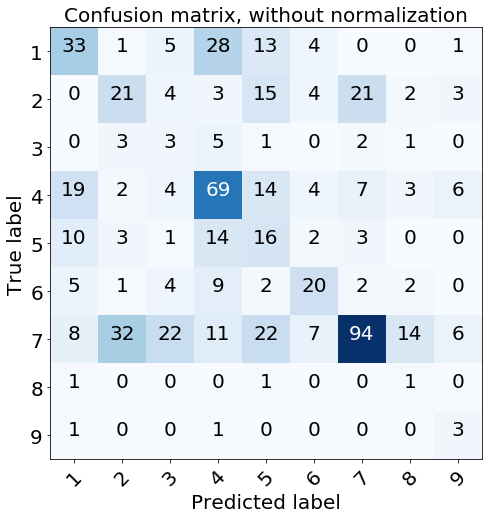

In [145]:
i = 0
y_pred = []
y_true = []



for words in test_topic_list:
    [y_pred.append(np.argmax(topic_word[:, vocab.index(w)])) for w in words]
    y_true.extend(np.ones(len(words), dtype=np.int32)*i)
    i+=1

    
cf_matrix = confusion_matrix(y_true, y_pred)

utils.plot_confusion_matrix(cf_matrix,normalize=False, classes=range(1, 1+n_topics),
                      title='Confusion matrix, without normalization')

f1= f1_score(y_true, y_pred, average='weighted')
print("F1 score of the guided LDA classifier: {}".format(f1))

# i = 0
# y_pred = []
# y_true = []
# for words in seed_topic_list:
#     [y_pred.append(np.argmax(topic_word[:, vocab.index(w)])) for w in words]
#     y_true.extend(np.ones(len(words), dtype=np.int32)*i)
#     i+=1

    
# cf_matrix = confusion_matrix(y_true, y_pred)

# plt.figure()
# utils.plot_confusion_matrix(cf_matrix, normalize=False, classes=range(1, 1+n_topics),
#                       title='Confusion matrix, without normalization')


In [146]:
y_pred_r = np.random.randint(9,  size=len(y_true))
# y_pred_r = np.random.choice(np.arange(9), size=len(y_true), p=weight)
f1_rand = f1_score(y_true, y_pred, average='weighted')

print("F1 score of random classification as baseline: {}".format(f1_rand))

F1 score of random classification as baseline: 0.44675402661554087


<a id='param'></a>
### Model selection - Parameter Gridsearch

In [147]:
if False:
    grid_params = {'n_topics' : [9],
                   'n_iter':[20,50,100,150], #
                   'alpha':np.logspace(-4.0, -0.3, num=7),
                   'eta':np.logspace(-4.0, -0.3, num=7),
                   'refresh':[500]}
    params={}
    utils.grid_search_lda(params, grid_params, tf, train_train, train_test, vocab)
# 
s_f1_ = '0.448076927194 0.459236452697 0.45324716172 0.451295506695 0.454878945517 0.474546851917 0.477447898482 0.479220228847 0.471182230125 0.505891846346 0.466392663552 0.470636698256 0.473063362984 0.450260402357 0.43647080367 0.454787670171 0.457314403964 0.450914353673 0.449959964167 0.444796789025 0.451839102299 0.438932777713 0.444699775748 0.440275261017 0.436853593801 0.428942445009 0.445041834633 0.428389941293 0.451337823095 0.454318065553 0.451894089833 0.451842867047 0.456392914259 0.473070450154 0.473410880004 0.471121841631 0.461276330854 0.467097373117 0.470296381972 0.46815903258 0.459275215747 0.447694977771 0.459476714153 0.448158793261 0.465011150518 0.433151639108 0.446422335998 0.443016787089 0.434025941816 0.438281322744 0.414386676647 0.429353186175 0.454767596499 0.417152757137 0.439917043057 0.441430221361 0.458506321693 0.458116266802 0.460461355756 0.47079434312 0.45845312628 0.453585164989 0.468933815015 0.496352790381 0.474528881357 0.455808596315 0.489745994303 0.467178124727 0.467354219364 0.470308823894 0.457020081827 0.432073218275 0.460779351782 0.436371736388 0.42464488074 0.423895653232 0.440718976364 0.427603788117 0.429953181144 0.427928389968 0.434041545913 0.422112476205 0.429619483926 0.399327361292 0.457127774602 0.451517048228 0.455409396076 0.443854370917 0.454584015884 0.471229069956 0.480589110585 0.473722575482 0.447375071334 0.462186544336 0.456608659881 0.453321940735 0.459113384828 0.45412664945 0.460271625115 0.415551823738 0.481173512019 0.423935357048 0.394271425457 0.408893138622 0.439252014921 0.426371836221 0.412340426711 0.398592882094 0.43380867121 0.403920429157 0.414314738975 0.387728038238 0.454119262177 0.442823512311 0.451734118856 0.452301632667 0.438969505679 0.449700208652 0.451193901273 0.461952987407 0.470533551177 0.480267962952 0.461465267126 0.46440960778 0.465775010214 0.459180437926 0.437629620416 0.416709333024 0.453905776168 0.407228133734 0.411624883972 0.401726003573 0.440370117826 0.412941299209 0.385544012745 0.368400064071 0.434867617637 0.39727416765 0.37973602224 0.364096403055 0.430528475056 0.452506555032 0.455774758214 0.45061232644 0.448289720343 0.453790668893 0.434127120905 0.473779293443 0.468863077641 0.461437646047 0.447553526986 0.456701040536 0.456600925974 0.459518308462 0.433336459606 0.400368176839 0.454272662744 0.413070098642 0.398626697072 0.397164971924 0.426761869078 0.403622495525 0.365285018605 0.373414525781 0.404898882322 0.392089821217 0.37310499709 0.371819371415 0.452188776153 0.45083722162 0.447957019408 0.43855743621 0.446992026459 0.450672841115 0.461341460707 0.46413168373 0.462632175274 0.431992268076 0.447558925152 0.457723397084 0.453714247069 0.438493126931 0.420368061317 0.373166180412 0.434016080656 0.389900904212 0.38109713051 0.371896117707 0.403966742271 0.391578036049 0.380437413632 0.374194119712 0.393256093764 0.379664957088 0.370895887968 0.369899347251'.replace(' ', ',')
# s_acc = '5.61623567211 5.44954828404 5.72981310651 5.61991079606 4.95761595658 4.75063882669 4.56337840129 4.61633619908 4.1001585359 3.87865127446 4.25912055956 3.89097631301 3.55447749565 3.63375820009 3.80805645843 3.62813392193 3.12896843327 3.08895178003 3.08520723056 3.11807543492 2.63041393395 2.73333015108 2.68854513025 2.73816094723 2.39263401182 2.36401972303 2.34602971862 2.36460088514 5.78900383492 5.58895194631 5.67076834974 5.61190347836 5.17390104611 4.87935460713 4.66258309235 4.69278251113 4.36465074137 4.2734756091 4.22849044861 4.2770143086 3.61167145466 3.67548111939 3.64268254779 3.79211026059 3.14901452207 3.22655178545 3.08862223246 3.27150208598 2.74699829894 2.74950584636 2.77785886493 2.80586569955 2.34485685033 2.39615852506 2.39353900937 2.35523453518 5.50223875698 5.73823834515 5.5750511897 5.56666049225 5.06771646389 4.89733468633 4.93636317851 4.66530916551 4.20505613764 4.46800330371 4.27523211368 4.28711203605 3.65852581883 3.70205355631 3.71476530132 3.99214916253 3.12989349837 3.32903665471 3.32364441783 3.33642408496 2.7387973522 2.7553729848 2.78238996539 2.85858844469 2.36723331754 2.40340135497 2.43417350301 2.47522277299 5.82775932931 6.03522272978 6.0096092674 6.07904661866 5.17041589631 5.12551865785 5.01009565342 5.18060300007 4.61032812421 4.51765107106 4.59574866565 4.62511053449 3.85874645578 4.00961236507 3.97802781959 4.24930684671 3.20974052473 3.45203469842 3.59764364815 3.58051127497 2.77663180035 2.93173068918 2.87361840219 3.04375712139 2.41230074006 2.5479128232 2.50251783605 2.64745236264 6.05312565268 6.30511690055 6.31999152343 6.39243962048 5.57612552959 5.56954096482 5.46673697075 5.41077021295 4.61282205876 4.62995756329 4.62615810777 4.73359220334 3.88725863721 4.01591034652 4.27437003866 4.34662074628 3.26544341422 3.69037930442 3.73198886879 3.70954686934 2.86105417317 2.92050029389 3.1133833412 3.24652040282 2.45933307377 2.60760778517 2.64857421881 2.71375397588 6.61377946141 6.48401213365 6.53435559927 6.50281954485 5.53811931891 5.85442002616 5.85244852634 5.64649398575 4.77529522647 4.87464453942 5.12081105472 5.16207965257 4.13222306845 4.28603850145 4.50851331426 4.65830341767 3.51571050336 3.86942231112 3.98980701222 3.99877248301 3.00751283626 3.1813447582 3.39281524231 3.35478307072 2.61942255911 2.67320935993 2.70899672671 2.7327324616 6.52039593342 6.77122831408 6.79394395415 6.98193895827 5.91573647652 6.00120652448 5.92179946855 6.0212780689 4.97239744759 5.37191450373 5.32920737994 5.18381421941 4.36377582232 4.60258213081 4.64942756863 5.13791918067 3.7878267634 4.18671796408 4.29898353623 4.24334563105 3.28487530936 3.37025613153 3.4323124964 3.4431865729 2.74441860141 2.74719501407 2.79541075401 2.84018518922'.replace(' ', ',')
# s_logloss = '0.424193548387 0.43064516129 0.424193548387 0.427419354839 0.427419354839 0.45 0.451612903226 0.456451612903 0.45 0.479032258065 0.445161290323 0.448387096774 0.445161290323 0.427419354839 0.412903225806 0.43064516129 0.433870967742 0.425806451613 0.41935483871 0.427419354839 0.422580645161 0.411290322581 0.414516129032 0.408064516129 0.406451612903 0.4 0.41935483871 0.398387096774 0.427419354839 0.43064516129 0.425806451613 0.43064516129 0.424193548387 0.446774193548 0.446774193548 0.448387096774 0.432258064516 0.443548387097 0.448387096774 0.445161290323 0.440322580645 0.425806451613 0.43064516129 0.420967741935 0.437096774194 0.406451612903 0.422580645161 0.412903225806 0.406451612903 0.408064516129 0.387096774194 0.4 0.424193548387 0.391935483871 0.408064516129 0.414516129032 0.433870967742 0.432258064516 0.440322580645 0.448387096774 0.429032258065 0.432258064516 0.45 0.475806451613 0.453225806452 0.435483870968 0.461290322581 0.445161290323 0.443548387097 0.443548387097 0.432258064516 0.404838709677 0.438709677419 0.411290322581 0.398387096774 0.396774193548 0.411290322581 0.395161290323 0.401612903226 0.396774193548 0.406451612903 0.408064516129 0.396774193548 0.382258064516 0.433870967742 0.424193548387 0.429032258065 0.417741935484 0.432258064516 0.448387096774 0.458064516129 0.445161290323 0.422580645161 0.441935483871 0.429032258065 0.432258064516 0.437096774194 0.425806451613 0.43064516129 0.387096774194 0.456451612903 0.395161290323 0.374193548387 0.388709677419 0.412903225806 0.396774193548 0.395161290323 0.379032258065 0.406451612903 0.385483870968 0.398387096774 0.367741935484 0.427419354839 0.41935483871 0.427419354839 0.425806451613 0.409677419355 0.427419354839 0.429032258065 0.437096774194 0.441935483871 0.453225806452 0.438709677419 0.443548387097 0.435483870968 0.43064516129 0.412903225806 0.385483870968 0.43064516129 0.382258064516 0.38064516129 0.383870967742 0.409677419355 0.398387096774 0.36935483871 0.35 0.404838709677 0.38064516129 0.361290322581 0.345161290323 0.404838709677 0.424193548387 0.429032258065 0.427419354839 0.420967741935 0.424193548387 0.412903225806 0.448387096774 0.445161290323 0.440322580645 0.420967741935 0.424193548387 0.437096774194 0.427419354839 0.406451612903 0.385483870968 0.424193548387 0.385483870968 0.379032258065 0.379032258065 0.409677419355 0.385483870968 0.343548387097 0.358064516129 0.377419354839 0.372580645161 0.356451612903 0.354838709677 0.429032258065 0.420967741935 0.416129032258 0.408064516129 0.422580645161 0.429032258065 0.433870967742 0.432258064516 0.433870967742 0.409677419355 0.41935483871 0.425806451613 0.427419354839 0.416129032258 0.390322580645 0.358064516129 0.403225806452 0.367741935484 0.364516129032 0.356451612903 0.383870967742 0.370967741935 0.361290322581 0.358064516129 0.370967741935 0.361290322581 0.354838709677 0.351612903226'.replace(' ', ',')


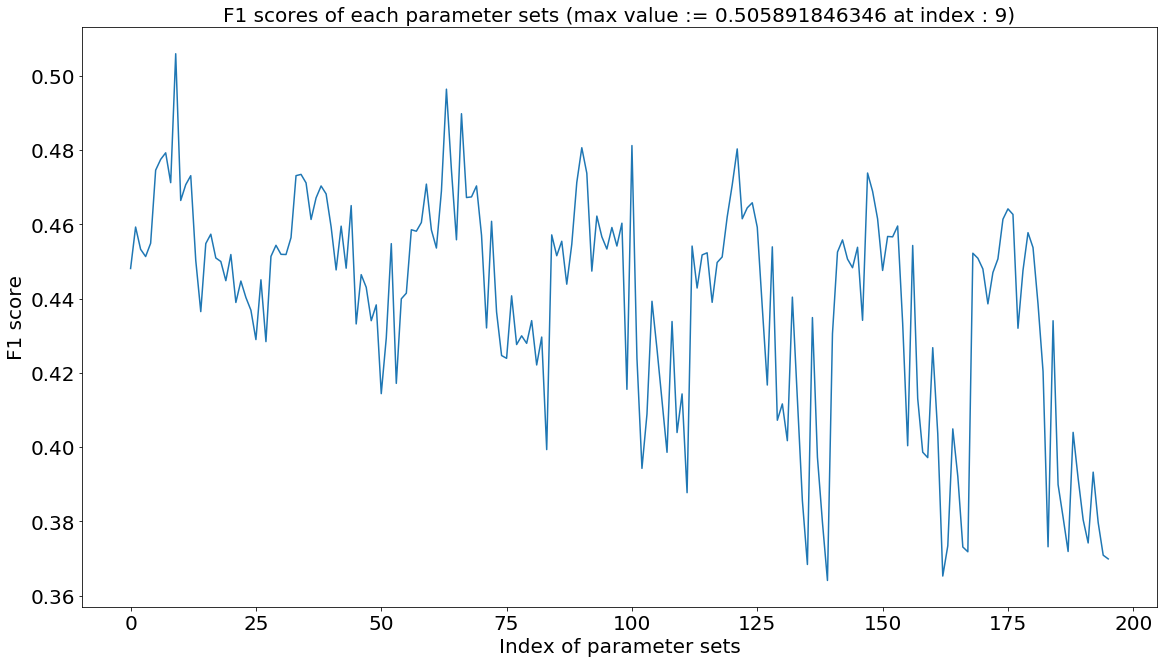

In [148]:
s_f1 = np.array(s_f1_.split(','))
s_f1 = s_f1.astype(np.float)
plt.plot(s_f1)
plt.title("F1 scores of each parameter sets (max value := {0} at index : {1})".format(np.max(s_f1), np.argmax(s_f1)), 
          fontsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams["figure.figsize"] = [16,9]
plt.tight_layout()
plt.ylabel('F1 score', fontsize=20)
plt.xlabel('Index of parameter sets', fontsize=20)
plt.show()

confusion matrix, cross entropy loss(log-loss), and Area under curve (AUC) are some of the most popular metrics